# Exploring Dandiset 001174: Calcium Imaging in SMA and M1 of Macaques

***

**⚠️ IMPORTANT: This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. Please be cautious when interpreting the code or results. Always verify the analysis with your own expertise before drawing scientific conclusions.**

***

## Overview of the Dandiset

This Dandiset contains calcium imaging data recorded from the supplementary motor area (SMA) and primary motor cortex (M1) in rhesus macaques. The researchers used one-photon calcium imaging with miniature microscopes to examine activity patterns of projection neurons in deep layers of these motor areas.

From the Dandiset description:

> The study of motor cortices in non-human primates is relevant to our understanding of human motor control, both in healthy conditions and in movement disorders. Calcium imaging and miniature microscopes allow the study of multiple genetically identified neurons with excellent spatial resolution. We used this method to examine activity patterns of projection neurons in deep layers of the supplementary motor (SMA) and primary motor areas (M1) in four rhesus macaques. We implanted gradient index lenses and expressed GCaMP6f to image calcium transients while the animals were at rest or engaged in an arm reaching task. We tracked the activity of SMA and M1 neurons across conditions, examined cell pairs for synchronous activity, and assessed whether SMA and M1 neuronal activation followed specific sequential activation patterns. We demonstrate the value of in vivo calcium imaging for studying patterns of activity in groups of corticofugal neurons in SMA and M1.

In this notebook, we will:

1. Load and explore the structure of an example NWB file from this Dandiset
2. Visualize the calcium imaging data and the ROIs (regions of interest)
3. Analyze fluorescence signals and event amplitudes
4. Explore the temporal patterns of neural activity
5. Visualize correlations and synchronous activity between neurons

## Required Packages

The following packages are required to run this notebook:

In [1]:
# Standard data science and visualization libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr

# Neurodata Without Borders (NWB) related libraries
import pynwb
import h5py
import remfile

# Set plotting style
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_theme()

## Loading the Dandiset

We'll use the DANDI API to access the Dandiset and list its contents:

In [2]:
from dandi.dandiapi import DandiAPIClient

# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("001174")
assets = list(dandiset.get_assets())

print(f"Found {len(assets)} assets in the dataset")
print("\nFirst 5 assets:")
for asset in assets[:5]:
    print(f"- {asset.path}")

Found 45 assets in the dataset

First 5 assets:
- sub-V/sub-V_ses-20230309T110929_ophys.nwb
- sub-Q/sub-Q_ophys.nwb
- sub-Q/sub-Q_ses-20220922T131747_ophys.nwb
- sub-Q/sub-Q_ses-20221003T131952_ophys.nwb
- sub-Q/sub-Q_ses-20221028T121142_ophys.nwb


## Explore a Specific NWB File

For this exploration, we'll focus on a specific NWB file from the dataset. We've selected a file that contains calcium imaging data from the supplementary motor area (SMA) during a spontaneous condition recording. This file is a reasonable size (about 1.5GB) and provides a good example of the data structure.

In [3]:
# Define the specific NWB file URL we're going to analyze
nwb_file_url = "https://api.dandiarchive.org/api/assets/b4e6bbf7-0564-4628-b8f0-680fd9b8d4ea/download/"
print(f"Loading NWB file from: {nwb_file_url}")

# Load the remote NWB file
remote_file = remfile.File(nwb_file_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

Loading NWB file from: https://api.dandiarchive.org/api/assets/b4e6bbf7-0564-4628-b8f0-680fd9b8d4ea/download/


## Basic Information About the Dataset

Let's start by examining the basic metadata of this NWB file to understand what kind of data it contains:

In [4]:
# Print basic information about the file
print(f"Session description: {nwb.session_description}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Species: {nwb.subject.species}")
print(f"Sex: {nwb.subject.sex}")
print(f"Age: {nwb.subject.age}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Available processing modules: {list(nwb.processing.keys())}")
print(f"Available acquisition data: {list(nwb.acquisition.keys())}")

Session description: Calcium imaging in SMA during the spontaneous condition
Subject ID: Q
Species: Macaca mulatta
Sex: F
Age: P5Y
Session start time: 2022-10-28 12:11:42.382000+00:00
Available processing modules: ['ophys']
Available acquisition data: ['OnePhotonSeries']


## Exploring the Calcium Imaging Data

The calcium imaging data is stored in the `OnePhotonSeries` object in the acquisition part of the NWB file. Let's examine its properties:

In [5]:
# Get information about the calcium imaging data
one_photon_series = nwb.acquisition["OnePhotonSeries"]
print(f"Imaging rate: {one_photon_series.rate} Hz")
print(f"Data shape: {one_photon_series.data.shape}")
print(f"Data type: {one_photon_series.data.dtype}")
print(f"Unit: {one_photon_series.unit}")
print(f"Description: {one_photon_series.description}")

Imaging rate: 10.01 Hz
Data shape: (12019, 320, 200)
Data type: uint16
Unit: fluorescence
Description: Miniscope imaging data


The shape of the data is `(frames, height, width)`, which represents a series of 2D images captured over time. The imaging was done at approximately 10 Hz.

## Visualizing a Sample Frame

Let's visualize a sample frame from the raw calcium imaging data to see what it looks like:

Sample frame shape: (320, 200)
Min intensity: 517, Max intensity: 2973


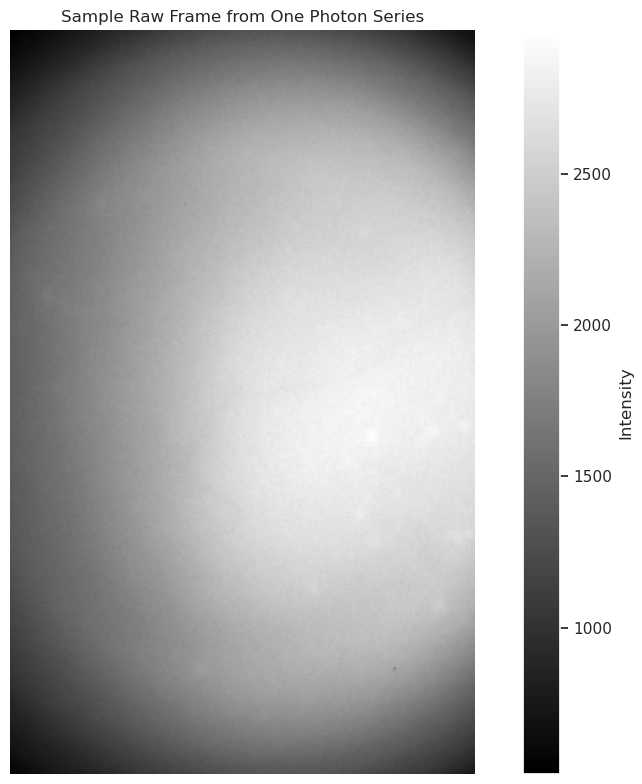

In [6]:
# Extract a single frame (the first frame)
sample_frame = one_photon_series.data[0, :, :]
print(f"Sample frame shape: {sample_frame.shape}")
print(f"Min intensity: {np.min(sample_frame)}, Max intensity: {np.max(sample_frame)}")

# Visualize the sample frame
plt.figure(figsize=(10, 8))
plt.imshow(sample_frame, cmap='gray')
plt.title('Sample Raw Frame from One Photon Series')
plt.colorbar(label='Intensity')
plt.axis('off')
plt.tight_layout()
plt.show()

## Exploring the ROIs (Regions of Interest)

The ROIs represent individual neurons or cell bodies that have been identified in the calcium imaging data. Let's examine information about these ROIs:

In [7]:
# Get information about the ROIs
image_seg = nwb.processing["ophys"].data_interfaces["ImageSegmentation"]
plane_seg = image_seg.plane_segmentations["PlaneSegmentation"]
num_rois = len(plane_seg.id[:])
print(f"Number of ROIs: {num_rois}")
print(f"ROI table columns: {plane_seg.colnames}")

Number of ROIs: 21
ROI table columns: ('image_mask',)


Each ROI has an associated image mask that defines its spatial extent. Let's visualize a few of these ROI masks to understand their shapes and distributions:

ROI 0 mask shape: (313, 181)
ROI 1 mask shape: (313, 181)
ROI 2 mask shape: (313, 181)
ROI 3 mask shape: (313, 181)
ROI 4 mask shape: (313, 181)
ROI 5 mask shape: (313, 181)
ROI 6 mask shape: (313, 181)
ROI 7 mask shape: (313, 181)


ROI 8 mask shape: (313, 181)


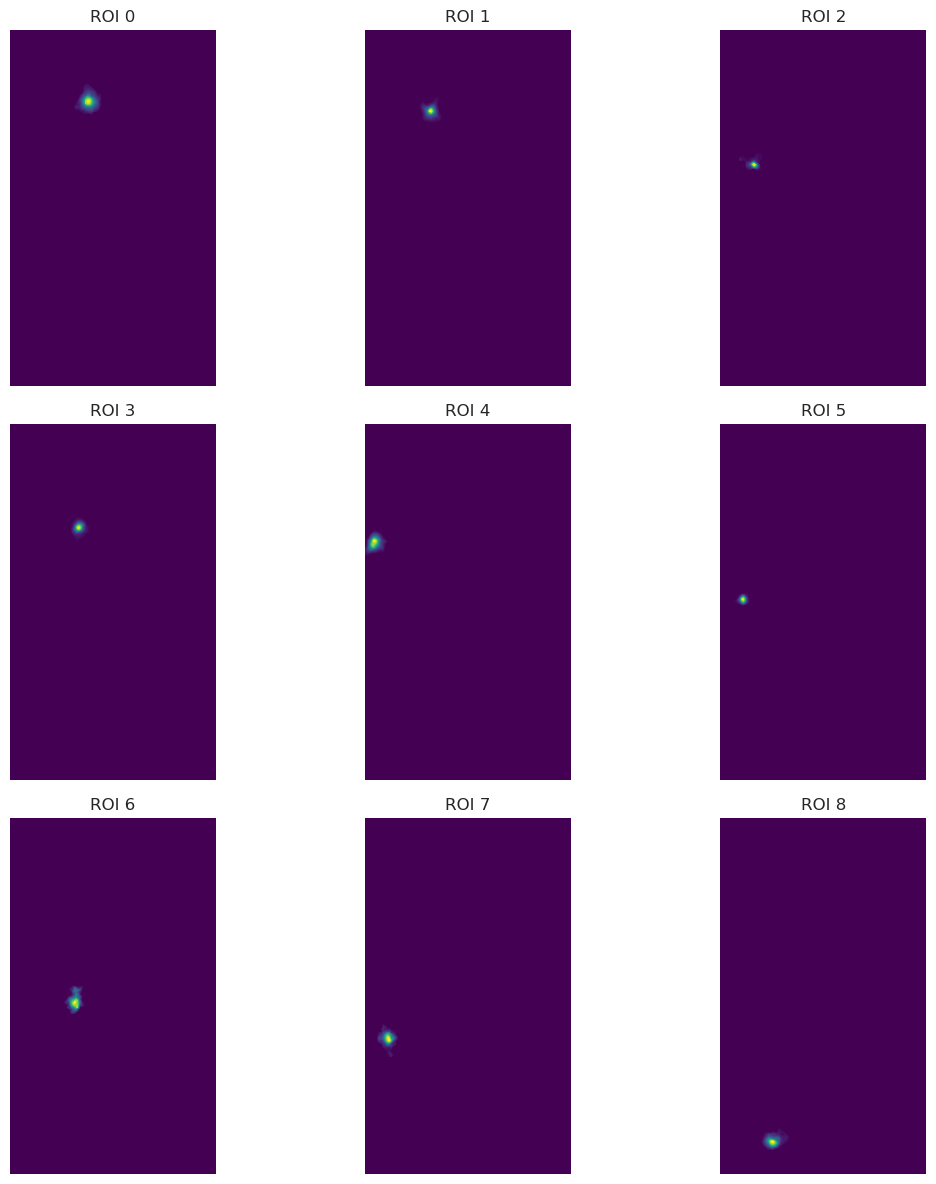

In [8]:
# Extract ROI masks for a few ROIs
num_to_plot = min(9, num_rois)
roi_masks = []

for i in range(num_to_plot):
    mask = plane_seg['image_mask'][i]
    roi_masks.append(mask)
    print(f"ROI {i} mask shape: {mask.shape}")

# Plot individual ROI masks
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i in range(num_to_plot):
    axes[i].imshow(roi_masks[i], cmap='viridis')
    axes[i].set_title(f'ROI {i}')
    axes[i].axis('off')
    
# Hide any unused subplots
for i in range(num_to_plot, len(axes)):
    axes[i].set_visible(False)
    
plt.tight_layout()
plt.show()

The masks show the spatial location and shape of each neuron in the field of view. Each bright spot represents a neuron's cell body that was identified during image segmentation.

## Analyzing Fluorescence Signals

Now let's examine the fluorescence signals associated with each ROI. These signals represent changes in calcium concentration within each neuron over time, which correlate with neural activity.

In [9]:
# Get fluorescence data
fluorescence = nwb.processing["ophys"].data_interfaces["Fluorescence"].roi_response_series["RoiResponseSeries"]
print(f"Fluorescence data shape: {fluorescence.data.shape}")
print(f"Fluorescence data type: {fluorescence.data.dtype}")
print(f"Fluorescence rate: {fluorescence.rate} Hz")

# Calculate some basic statistics for fluorescence
# Load a sample of the data to avoid memory issues
sample_size = 1000  # First 1000 timepoints
sample_data = fluorescence.data[:sample_size, :]

# Calculate statistics
mean_per_roi = np.mean(sample_data, axis=0)
std_per_roi = np.std(sample_data, axis=0)
max_per_roi = np.max(sample_data, axis=0)
min_per_roi = np.min(sample_data, axis=0)

# Print statistics for the first few ROIs
print("\nFluorescence statistics for the first 5 ROIs:")
for i in range(min(5, fluorescence.data.shape[1])):
    print(f"ROI {i}: Mean = {mean_per_roi[i]:.4f}, Std = {std_per_roi[i]:.4f}, Min = {min_per_roi[i]:.4f}, Max = {max_per_roi[i]:.4f}")

Fluorescence data shape: (12019, 21)
Fluorescence data type: float32
Fluorescence rate: 10.01 Hz

Fluorescence statistics for the first 5 ROIs:
ROI 0: Mean = 0.5674, Std = 1.6401, Min = 0.0000, Max = 17.4769
ROI 1: Mean = 0.0064, Std = 0.0246, Min = 0.0000, Max = 0.2163
ROI 2: Mean = 0.0585, Std = 0.2123, Min = 0.0000, Max = 1.4849
ROI 3: Mean = 0.3461, Std = 0.6735, Min = 0.0000, Max = 4.0272
ROI 4: Mean = 2.3882, Std = 4.5917, Min = 0.0000, Max = 26.4070


Let's visualize the mean fluorescence for each ROI to see which neurons are more active on average:

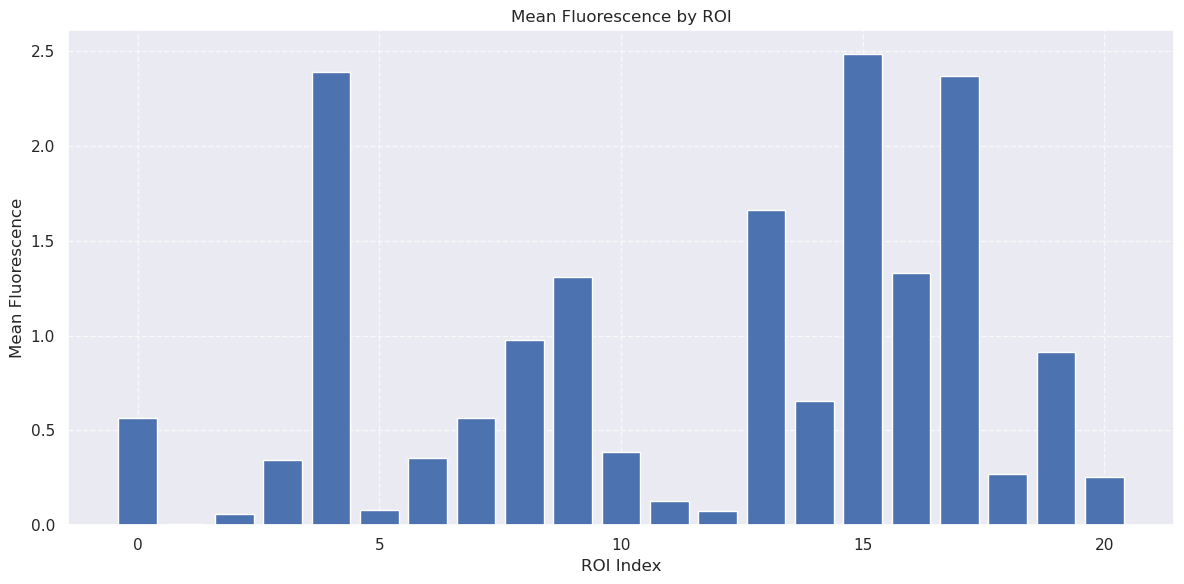

In [10]:
# Plot mean fluorescence for each ROI
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(mean_per_roi)), mean_per_roi)
plt.xlabel('ROI Index')
plt.ylabel('Mean Fluorescence')
plt.title('Mean Fluorescence by ROI')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Now let's visualize fluorescence traces for a few ROIs to see how neural activity changes over time:

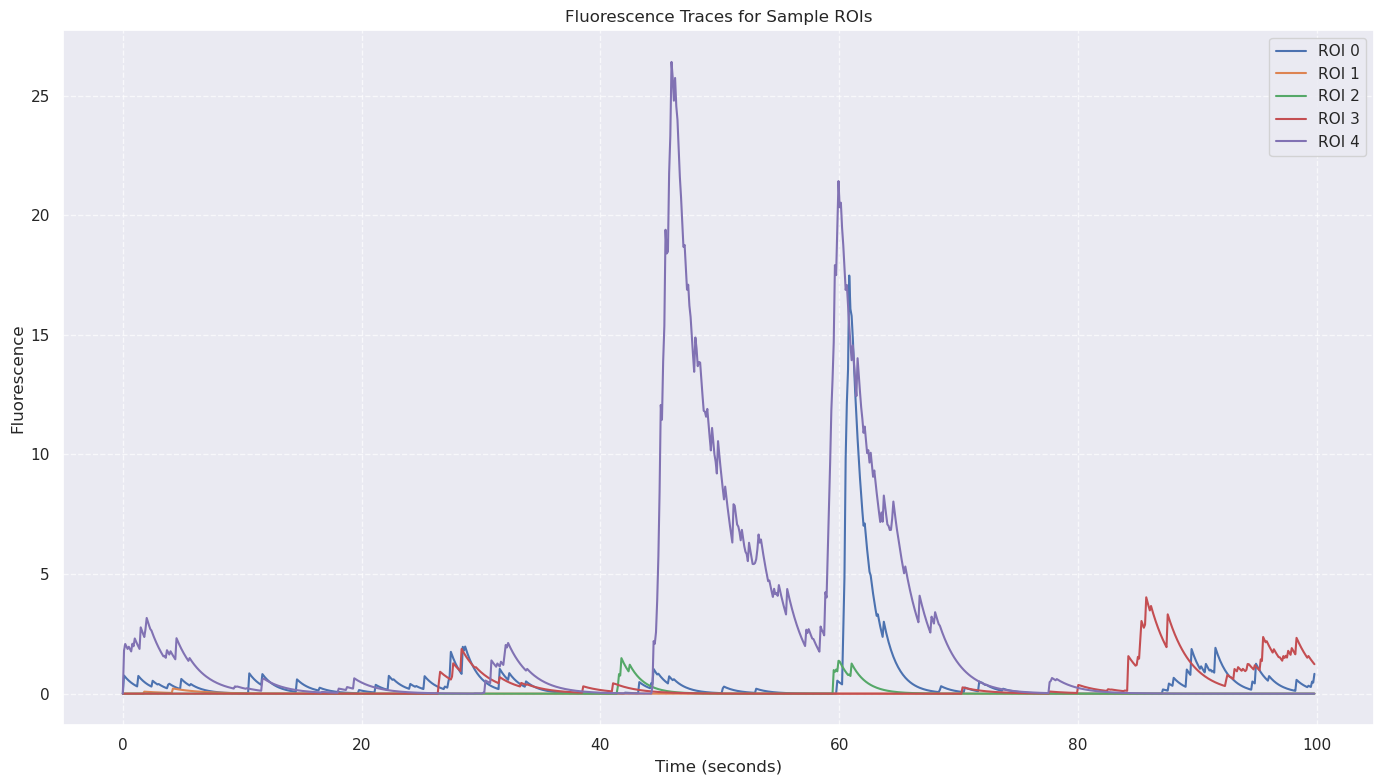

In [11]:
# Create a time vector for a sample period
sample_size = 1000  # First 1000 timepoints
time = np.arange(sample_size) / fluorescence.rate  # Time in seconds

# Plot fluorescence traces for a few ROIs
plt.figure(figsize=(14, 8))
for i in range(min(5, fluorescence.data.shape[1])):  # First 5 ROIs
    plt.plot(time, sample_data[:, i], label=f'ROI {i}')
    
plt.xlabel('Time (seconds)')
plt.ylabel('Fluorescence')
plt.title('Fluorescence Traces for Sample ROIs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Analyzing Event Amplitudes

The event amplitudes represent detected calcium events or spikes in neural activity. Let's examine this data:

Event amplitude data shape: (12019, 21)
Event amplitude data type: float64


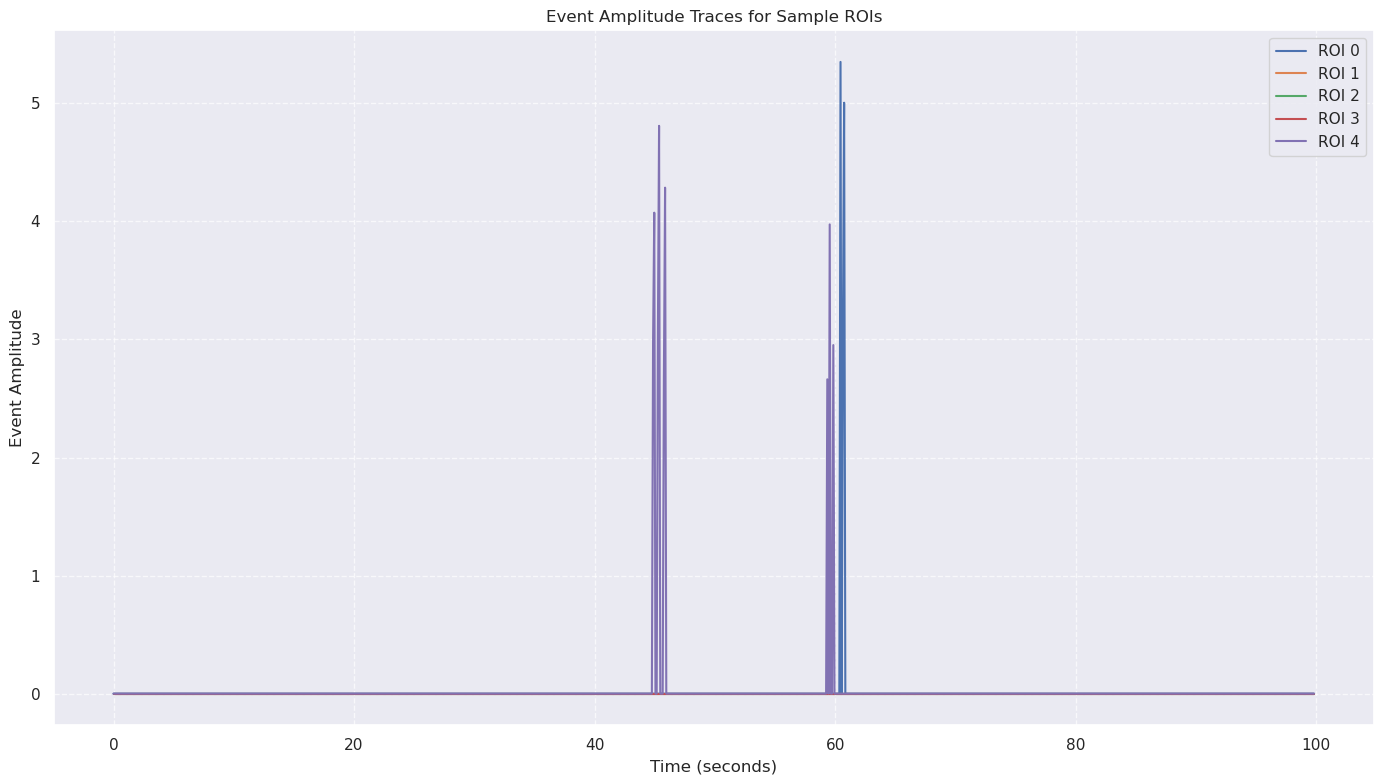

In [12]:
# Get event amplitude data
event_amplitude = nwb.processing["ophys"].data_interfaces["EventAmplitude"]
print(f"Event amplitude data shape: {event_amplitude.data.shape}")
print(f"Event amplitude data type: {event_amplitude.data.dtype}")

# Plot event amplitude data for a few ROIs
sample_event_data = event_amplitude.data[:sample_size, :]
plt.figure(figsize=(14, 8))
for i in range(min(5, event_amplitude.data.shape[1])):  # First 5 ROIs
    plt.plot(time, sample_event_data[:, i], label=f'ROI {i}')
    
plt.xlabel('Time (seconds)')
plt.ylabel('Event Amplitude')
plt.title('Event Amplitude Traces for Sample ROIs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Unlike the continuous fluorescence traces, the event amplitude data shows discrete events or "spikes" that represent detected neural firing events.

## Temporal Patterns of Neural Activity

To better understand the overall patterns of neural activity, let's create a heatmap of all ROIs' activity over time:

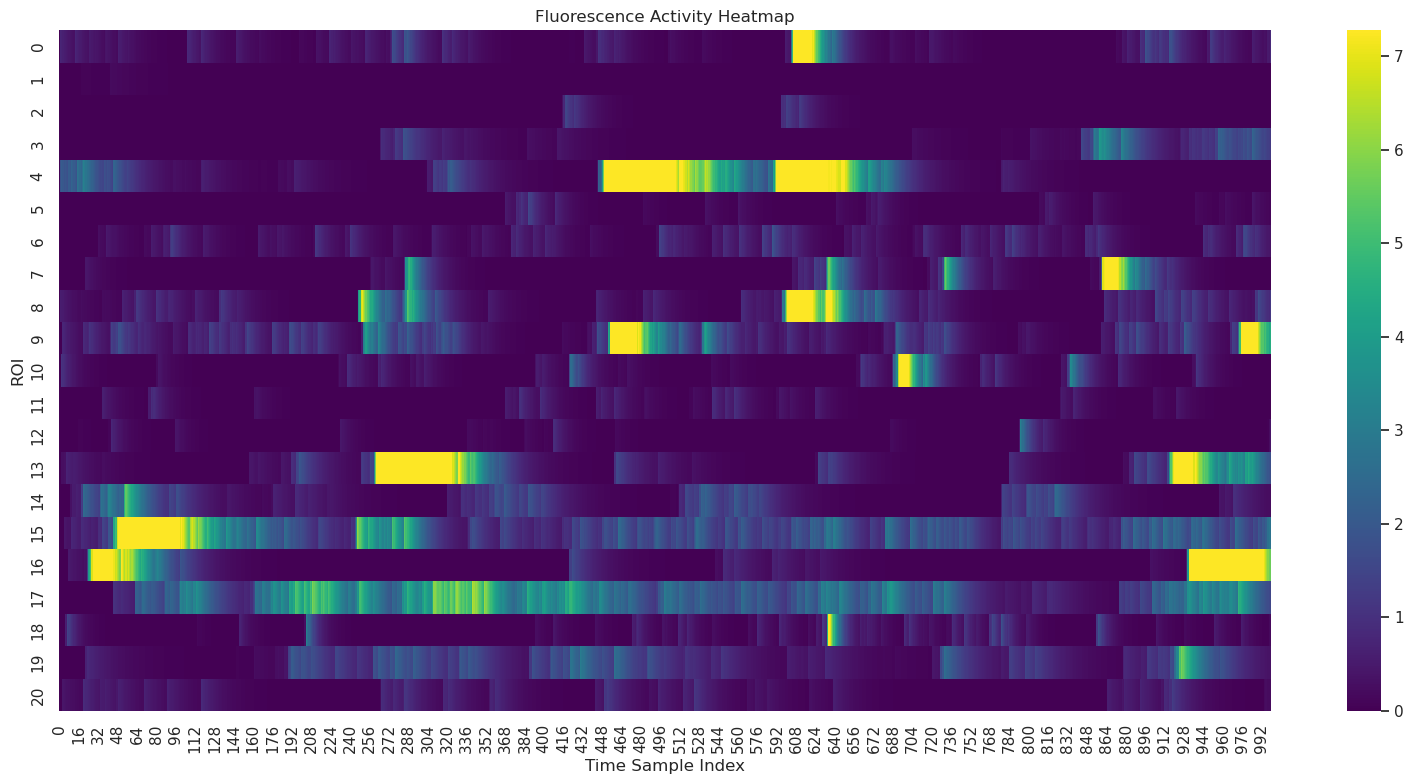

In [13]:
# Create a heatmap of ROI activity
plt.figure(figsize=(16, 8))
sns.heatmap(sample_data.T, cmap='viridis', robust=True)
plt.xlabel('Time Sample Index')
plt.ylabel('ROI')
plt.title('Fluorescence Activity Heatmap')
plt.tight_layout()
plt.show()

Now let's create a binary event raster plot to show when each neuron is active:

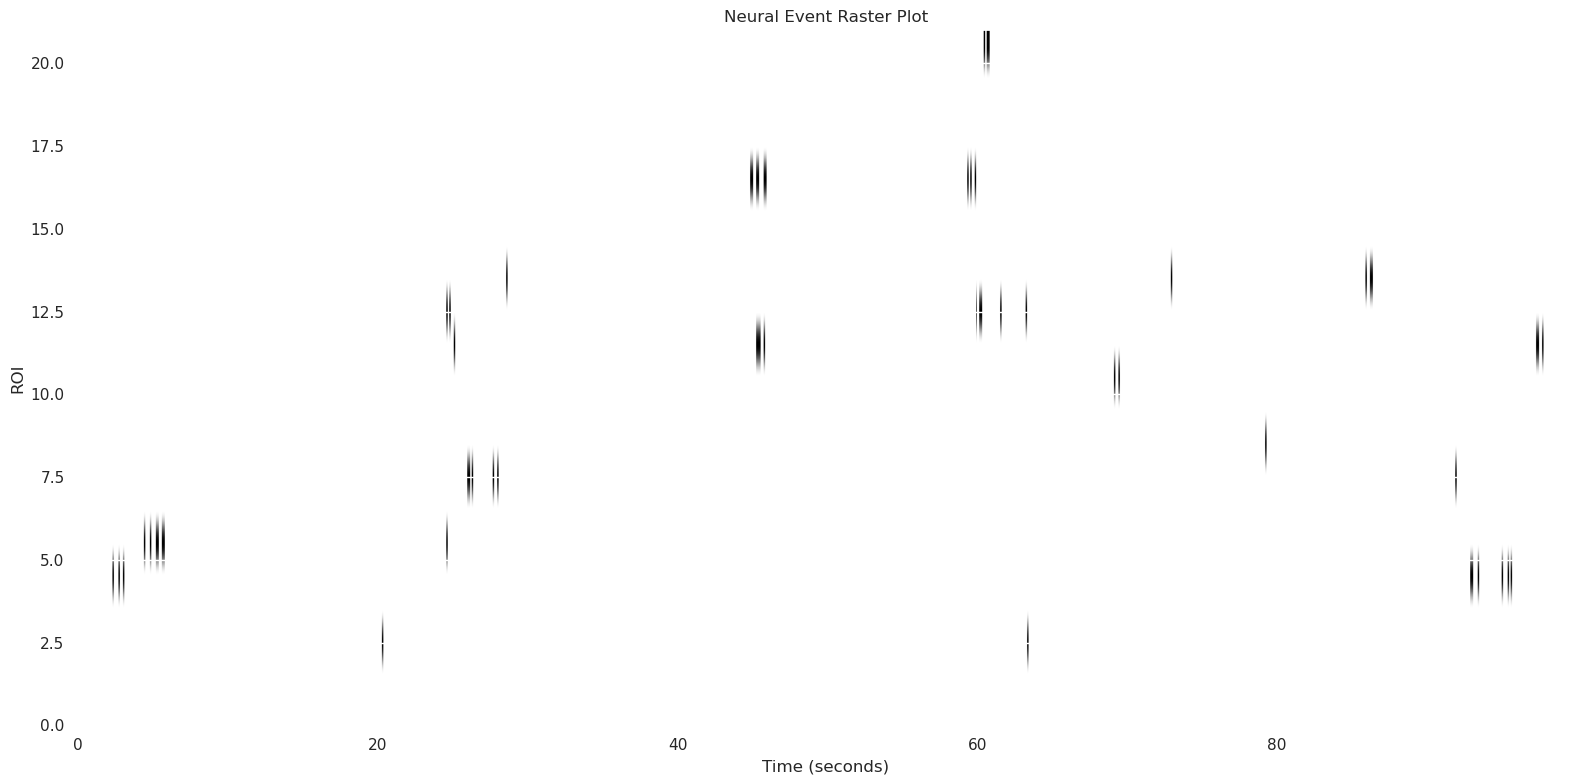

In [14]:
# Create a binary event raster plot
binary_events = (sample_event_data > 0).astype(int)

plt.figure(figsize=(16, 8))
plt.imshow(binary_events.T, aspect='auto', cmap='binary', 
           extent=[0, time[-1], 0, event_amplitude.data.shape[1]])
plt.xlabel('Time (seconds)')
plt.ylabel('ROI')
plt.title('Neural Event Raster Plot')
plt.tight_layout()
plt.show()

Let's examine the total activity across all ROIs over time:

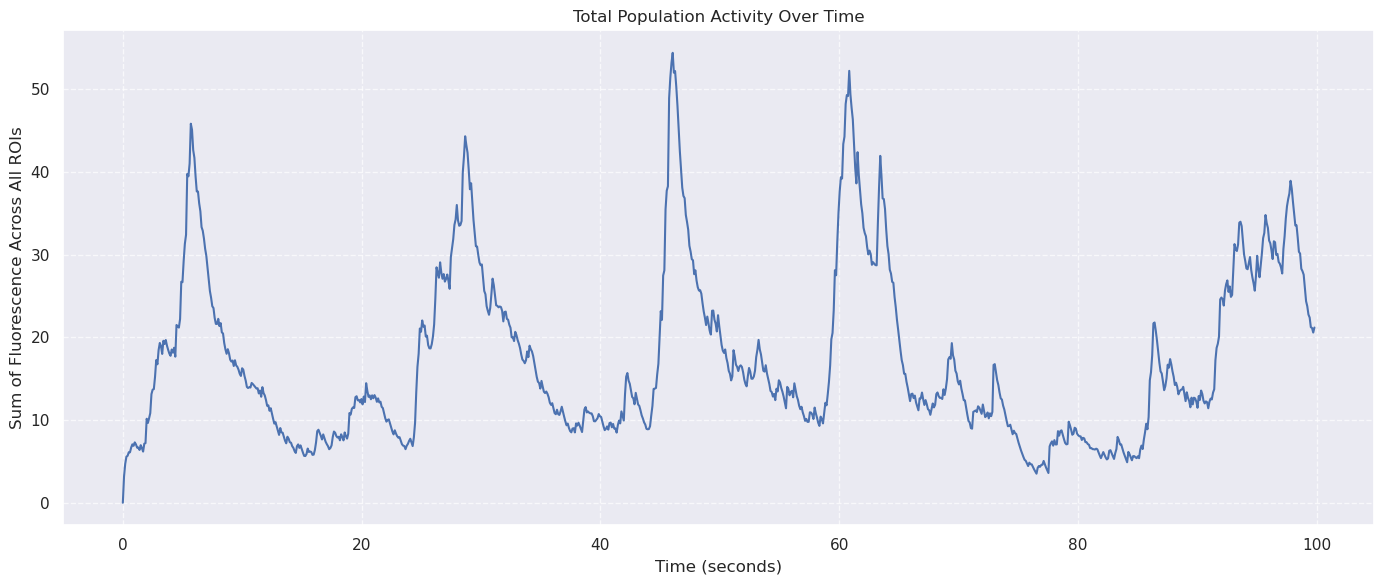

In [15]:
# Calculate total activity across all ROIs
total_activity = np.sum(sample_data, axis=1)

plt.figure(figsize=(14, 6))
plt.plot(time, total_activity)
plt.xlabel('Time (seconds)')
plt.ylabel('Sum of Fluorescence Across All ROIs')
plt.title('Total Population Activity Over Time')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

And calculate the number of simultaneously active neurons at each timepoint:

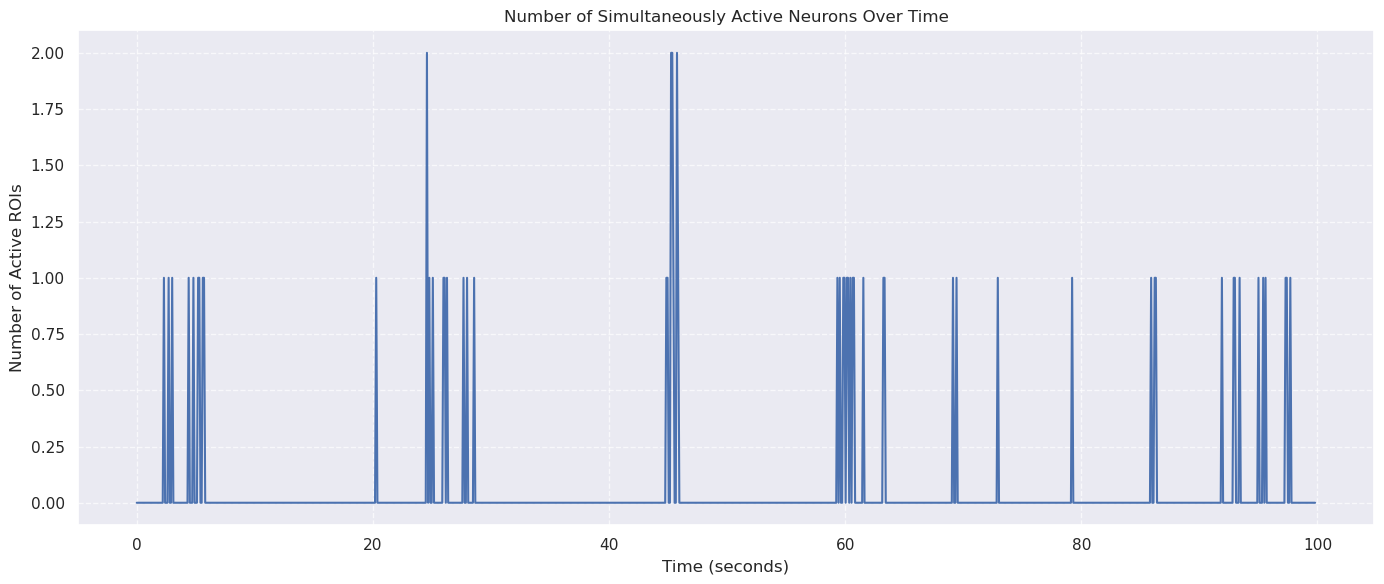

In [16]:
# Calculate the number of active neurons at each timepoint
active_count = np.sum(binary_events, axis=1)

plt.figure(figsize=(14, 6))
plt.plot(time, active_count)
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Active ROIs')
plt.title('Number of Simultaneously Active Neurons Over Time')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Correlation Between ROIs

Let's analyze the correlations between different ROIs to see if there are patterns of coordinated activity:

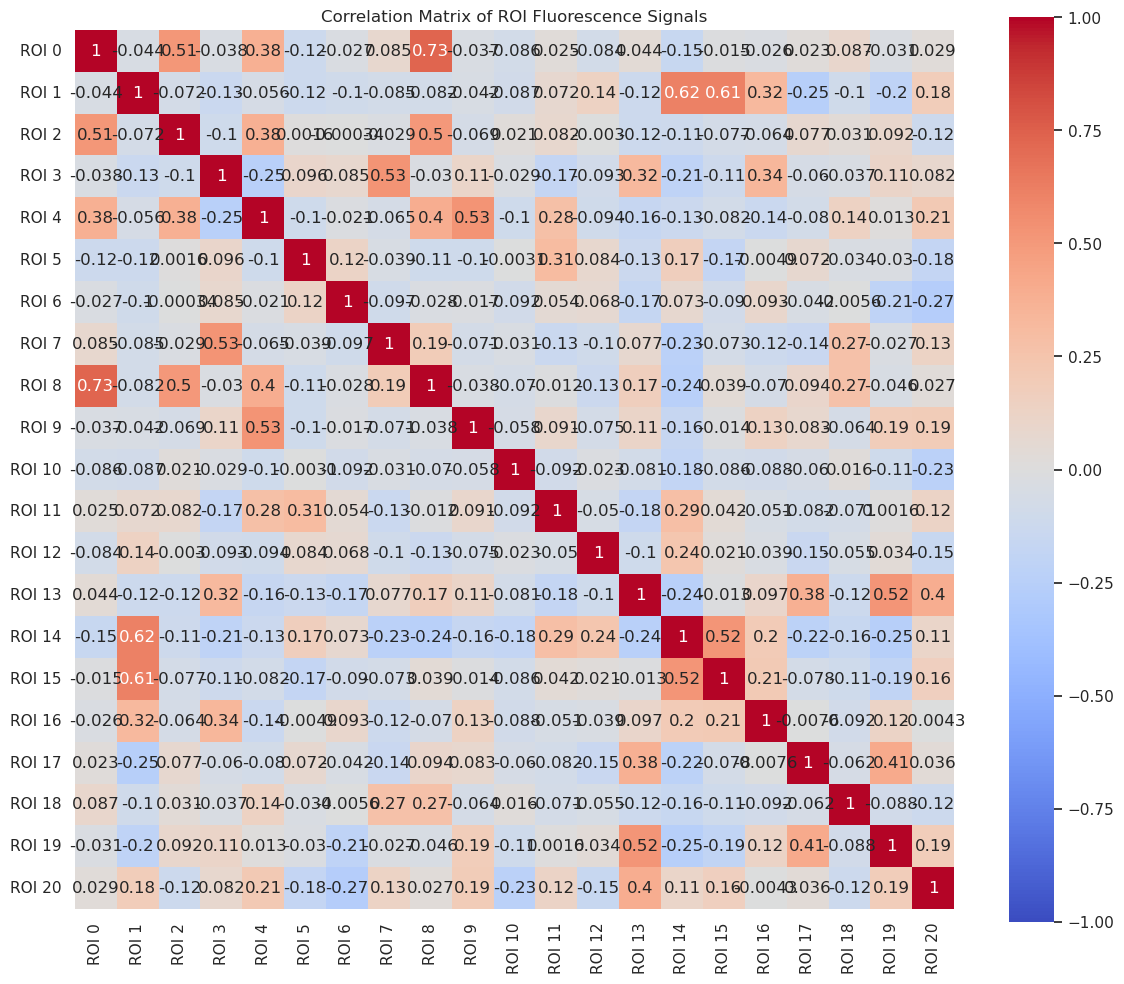

In [17]:
# Calculate the correlation matrix
correlation_matrix = np.zeros((sample_data.shape[1], sample_data.shape[1]))

for i in range(sample_data.shape[1]):
    for j in range(sample_data.shape[1]):
        if i == j:
            correlation_matrix[i, j] = 1.0  # Perfect correlation with itself
        else:
            # Calculate Pearson correlation
            corr, _ = pearsonr(sample_data[:, i], sample_data[:, j])
            correlation_matrix[i, j] = corr

# Create a DataFrame for the correlation matrix
roi_ids = [f"ROI {i}" for i in range(sample_data.shape[1])]
corr_df = pd.DataFrame(correlation_matrix, index=roi_ids, columns=roi_ids)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title('Correlation Matrix of ROI Fluorescence Signals')
plt.tight_layout()
plt.show()

## Loading a Larger Segment of Data for Further Analysis

Now that we have a basic understanding of the data, let's load a larger segment to explore for longer temporal patterns:

In [18]:
# Load a larger segment (e.g., 5 minutes)
five_min_samples = int(5 * 60 * fluorescence.rate)
segment_data = fluorescence.data[:five_min_samples, :]
segment_time = np.arange(five_min_samples) / fluorescence.rate

print(f"Loaded {five_min_samples} samples ({five_min_samples/fluorescence.rate/60:.2f} minutes) for analysis")

Loaded 3003 samples (5.00 minutes) for analysis


Let's focus on the top 5 most active ROIs to examine their patterns over a longer period:

Top 5 most active ROIs: [1 2 3 4 5]


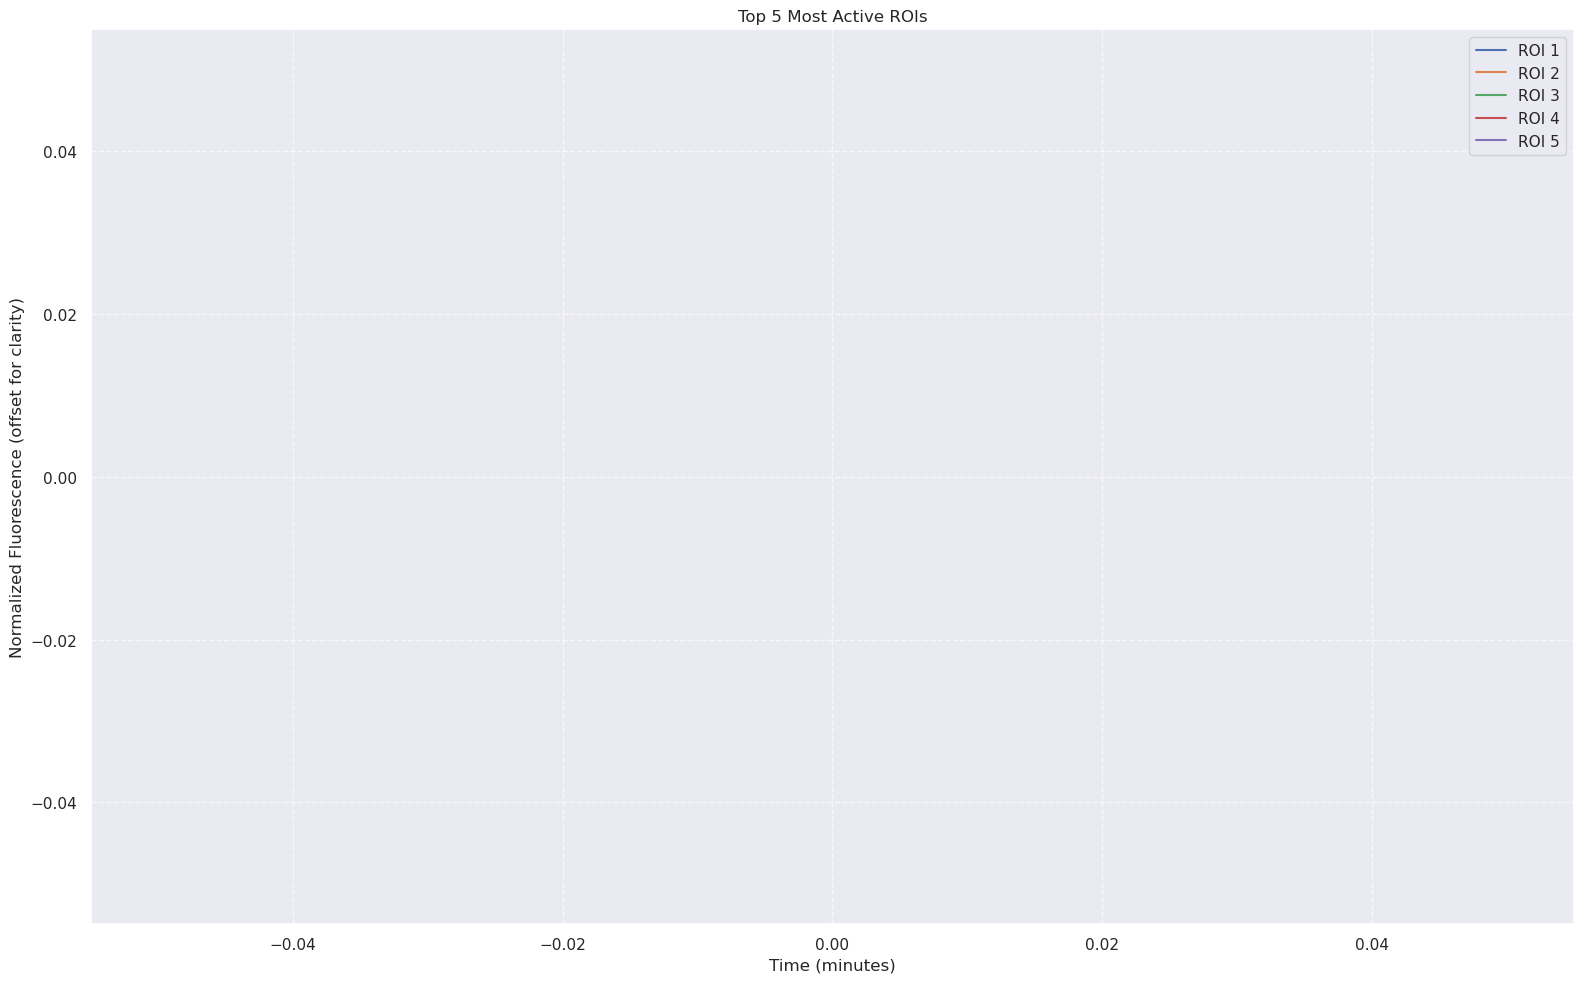

In [19]:
# Identify the top 5 most active ROIs based on mean fluorescence
roi_mean_activity = np.mean(segment_data, axis=0)
top_roi_indices = np.argsort(roi_mean_activity)[-5:][::-1]  # Sort descending
print("Top 5 most active ROIs:", top_roi_indices)

# Plot fluorescence for the top 5 most active ROIs
plt.figure(figsize=(16, 10))
for i, roi_idx in enumerate(top_roi_indices):
    # Normalize and offset each trace for better visualization
    trace = segment_data[:, roi_idx]
    normalized_trace = (trace - np.min(trace)) / (np.max(trace) - np.min(trace))
    offset_trace = normalized_trace + i
    
    plt.plot(segment_time / 60, offset_trace, label=f'ROI {roi_idx}')

plt.xlabel('Time (minutes)')
plt.ylabel('Normalized Fluorescence (offset for clarity)')
plt.title('Top 5 Most Active ROIs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Summary and Findings

In this notebook, we've explored calcium imaging data from Dandiset 001174, which contains recordings from the supplementary motor area (SMA) and primary motor cortex (M1) in rhesus macaques. Our analysis focused on a single NWB file from this dataset.

Key findings:

1. The dataset contains calcium imaging data recorded at approximately 10 Hz, with each frame having dimensions of 320x200 pixels.

2. We identified 21 regions of interest (ROIs) representing individual neurons in the field of view.

3. The fluorescence signals show variable patterns of activity across different neurons, with some neurons being consistently more active than others.

4. The event amplitude data reveals discrete neural firing events, showing when neurons are most strongly activated.

5. Temporal analysis revealed some instances of coordinated activity across multiple neurons, but many neurons also show independent activity patterns.

6. Correlation analysis showed limited strong correlations between ROIs, suggesting that most neurons in this recording are functioning relatively independently.

This exploration provides just a starting point for more detailed analyses of this dataset. Researchers could further investigate:

- Relationships between neural activity and behavioral events
- Differences in activity patterns between SMA and M1
- Changes in neural activity across different recording sessions or conditions
- More advanced analyses of functional connectivity between neurons
- Comparison of activity patterns across different subjects

## Future Directions

Future analyses could include:

1. Comparing activity patterns across different sessions or experimental conditions
2. Analyzing activity related to specific behavioral events or task phases
3. Examining sequential activation patterns across neural populations
4. Applying more advanced analytical methods such as dimensionality reduction or network analysis
5. Comparing calcium imaging data with other modalities such as electrophysiology

The rich dataset provided by the researchers offers many opportunities for further exploration and discovery.